In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import time
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys

In [2]:
class Matryoshka_CE_Loss(nn.Module):
    def __init__(self, relative_importance=None, **kwargs):
        super(Matryoshka_CE_Loss, self).__init__()
        self.criterion = nn.CrossEntropyLoss(**kwargs)
        self.relative_importance = relative_importance

    def forward(self, output, target):
        losses = torch.stack([self.criterion(output_i, target) for output_i in output])
        rel_importance = torch.ones_like(losses) if self.relative_importance is None else torch.as_tensor(self.relative_importance, device=losses.device).clone().detach()        
        weighted_losses = rel_importance * losses
        return weighted_losses.mean()

class MRL_Linear_Layer(nn.Module):
    def __init__(self, nesting_list, num_classes=10, efficient=False, **kwargs):
        super(MRL_Linear_Layer, self).__init__()
        self.nesting_list = nesting_list
        self.num_classes = num_classes
        self.efficient = efficient
        if self.efficient:
            self.nesting_classifier_0 = nn.Linear(nesting_list[-1], self.num_classes, **kwargs)
        else:
            for i, num_feat in enumerate(self.nesting_list):
                setattr(self, f"nesting_classifier_{i}", nn.Linear(num_feat, self.num_classes, **kwargs))

    def forward(self, x):
        nesting_logits = ()
        for i, num_feat in enumerate(self.nesting_list):
            if self.efficient:
                if self.nesting_classifier_0.bias is None:
                    nesting_logits += (torch.matmul(x[:, :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()), )
                else:
                    nesting_logits += (torch.matmul(x[:, :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()) + self.nesting_classifier_0.bias, )
            else:
                nesting_logits += (getattr(self, f"nesting_classifier_{i}")(x[:, :num_feat]),)
        return nesting_logits

In [3]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet9(nn.Module):
    def __init__(self, nesting_list, num_classes=10):
        super(ResNet9, self).__init__()
        self.in_planes = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        
        self.linear = MRL_Linear_Layer(nesting_list, num_classes=num_classes, efficient=False)
        
    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = nn.functional.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_size = int(0.9 * len(train_set))
val_size = len(train_set) - train_size
train_set, val_set = torch.utils.data.random_split(train_set, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=1)
val_loader = DataLoader(val_set, batch_size=100, shuffle=False, num_workers=1)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
nesting_list = [64]
relative_importance = [1.0]
relative_importance_tensor = torch.tensor(relative_importance, device=device)

model = ResNet9(nesting_list, num_classes=10)
model = model.to(device)
criterion = Matryoshka_CE_Loss(relative_importance=relative_importance_tensor)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

In [7]:
def train(epoch):
    model.train()
    train_loss = 0
    correct = {n: 0 for n in nesting_list}
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        for i, n in enumerate(nesting_list):
            _, predicted = outputs[i].max(1)
            correct[n] += predicted.eq(targets).sum().item()
        total += targets.size(0)
    
    avg_acc = 100. * sum(correct.values()) / (total * len(nesting_list))
    return train_loss/len(train_loader), avg_acc

In [8]:
def validate():
    model.eval()
    val_loss = 0
    correct = {n: 0 for n in nesting_list}
    total = 0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
            for i, n in enumerate(nesting_list):
                _, predicted = outputs[i].max(1)
                correct[n] += predicted.eq(targets).sum().item()
            total += targets.size(0)
    
    avg_acc = 100. * sum(correct.values()) / (total * len(nesting_list))
    return val_loss/len(val_loader), avg_acc

In [9]:
def test():
    model.eval()
    test_loss = 0
    correct_top1 = {n: 0 for n in nesting_list}
    correct_top5 = {n: 0 for n in nesting_list}
    total = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            
            for i, n in enumerate(nesting_list):
                _, predicted = outputs[i].max(1)
                correct_top1[n] += predicted.eq(targets).sum().item()
                
                _, top5_pred = outputs[i].topk(5, 1, True, True)
                correct_top5[n] += top5_pred.eq(targets.view(-1, 1)).sum().item()
            
            total += targets.size(0)

    avg_top1 = sum(100. * correct_top1[n] / total for n in nesting_list) / len(nesting_list)
    avg_top5 = sum(100. * correct_top5[n] / total for n in nesting_list) / len(nesting_list)
    
    print("\n┌──────────┬────────────┬────────────┐")
    print(f"│ {'Size':^8} │ {'Top-1 Acc':^10} │ {'Top-5 Acc':^10} │")
    print("├──────────┼────────────┼────────────┤")
    
    for n in nesting_list:
        top1 = 100. * correct_top1[n] / total
        top5 = 100. * correct_top5[n] / total
        print(f"│ {n:^8} │ {top1:>9.2f}% │ {top5:>9.2f}% │")
    
    print("├──────────┼────────────┼────────────┤")
    print(f"│ {'Average':^8} │ {avg_top1:>9.2f}% │ {avg_top5:>9.2f}% │")
    print("└──────────┴────────────┴────────────┘")
    
    return avg_top1

Training: 100%|█| 100/100 [30:28<00:00, 18.28s/it, Train Loss=0.003, Val Acc=94.


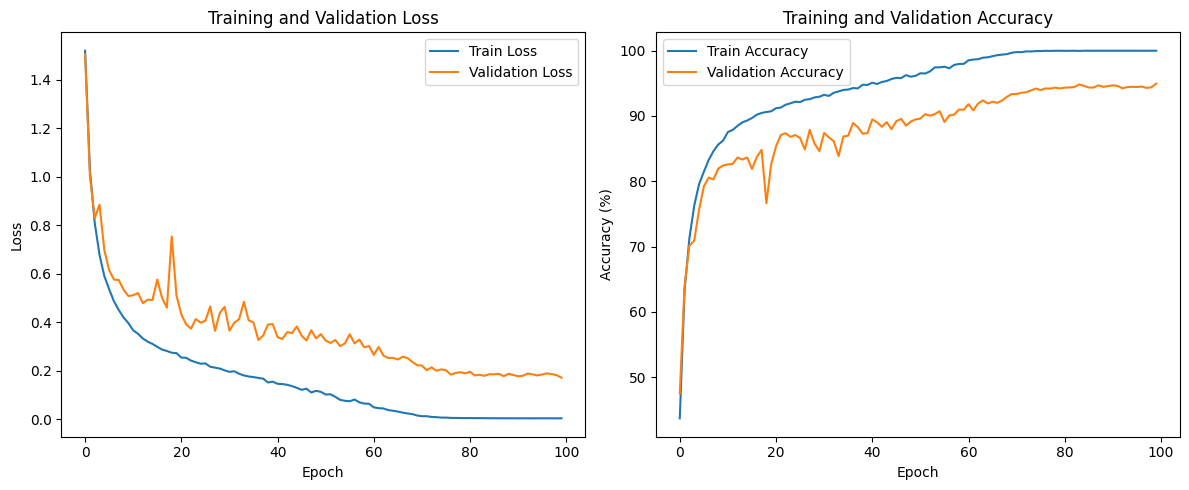


Final Test Results:

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│    64    │     94.27% │     99.85% │
├──────────┼────────────┼────────────┤
│ Average  │     94.27% │     99.85% │
└──────────┴────────────┴────────────┘


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


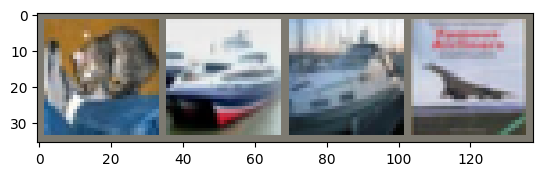

GroundTruth: 3 8 8 0

Predictions for different nesting sizes:
Size 64: 3 8 8 0


In [10]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

best_acc = 0

with tqdm(range(100), desc='Training', file=sys.stdout, colour='green') as pbar:
    for epoch in pbar:
        train_loss, train_acc = train(epoch)
        val_loss, val_acc = validate()
        scheduler.step()

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model_resnet9_mrl_64.pth')
            
        pbar.set_postfix({
            'Train Loss': f'{train_loss:.3f}',
            'Val Acc': f'{val_acc:.2f}%',
            'LR': f'{optimizer.param_groups[0]["lr"]:.5f}'
        })

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

print("\nFinal Test Results:")
test()

def imshow(img):
    img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) + \
          torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth:', ' '.join(f'{labels[j]}' for j in range(4)))

print("\nPredictions for different nesting sizes:")
outputs = model(images[:4].to(device))
for i, n in enumerate(nesting_list):
    _, predicted = torch.max(outputs[i], 1)
    print(f"Size {n}: {' '.join(f'{predicted[j].item()}' for j in range(4))}")